In [1]:
# Cell 1 — Load sequences and labels
import numpy as np
import pandas as pd
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Masking

DATA_FILE = Path(r"C:\Users\aibel\Desktop\Heizel Ann Joseph\Parkinsons Disease\data\processed\all_sequences.npz")

data = np.load(DATA_FILE, allow_pickle=True)

sequences = data["sequences"]
labels = data["labels"]

print("Loaded sequences:", len(sequences))
print("Example sequence shape:", sequences[0].shape)
print("Class counts:", pd.Series(labels).value_counts())


Loaded sequences: 597
Example sequence shape: (175, 13)
Class counts: 0    302
1    295
Name: count, dtype: int64


In [2]:
# Cell 2 — scale features, pad sequences, train/test split
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# load sequences & labels (if not in memory)
# sequences, labels already loaded in Cell 1 if you followed previous cell
# sequences: list of (n_substrokes, n_features) arrays
# labels: list/array of 0/1

# convert to list of numpy arrays (should already be)
seqs = [np.asarray(s, dtype=float) for s in sequences]
y = np.asarray(labels, dtype=int)

# stack all substroke feature rows to fit scaler
all_rows = np.vstack(seqs)   # (total_substrokes, n_features)
scaler = StandardScaler()
scaler.fit(all_rows)

# apply scaler to each sequence
seqs_scaled = [scaler.transform(s) for s in seqs]

# save scaler for later (important)
SCALER_PATH = Path(r"C:\Users\aibel\Desktop\Heizel Ann Joseph\Parkinsons Disease\data\processed\scaler.pkl")
with open(SCALER_PATH, "wb") as f:
    pickle.dump(scaler, f)

# pad sequences to the same length (pad with zeros)
max_len = max([s.shape[0] for s in seqs_scaled])
print("Max timesteps (substrokes) across samples:", max_len)
X = pad_sequences(seqs_scaled, padding='post', dtype='float32', value=0.0)  # shape (N, max_len, n_features)
print("Padded X shape:", X.shape)

# train / val / test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val,  y_train, y_val  = train_test_split(X_train, y_train, test_size=0.17647, stratify=y_train, random_state=42)
# second split makes val ~15% and train ~70% (approx)

print("Shapes:")
print(" X_train:", X_train.shape, "y_train:", y_train.shape)
print(" X_val:", X_val.shape, "y_val:", y_val.shape)
print(" X_test:", X_test.shape, "y_test:", y_test.shape)

# compute class weights to balance training
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
class_weights_raw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = {int(c): float(w) for c, w in zip(classes, class_weights_raw)}
print("Class weights (train):", class_weights)


Max timesteps (substrokes) across samples: 1135
Padded X shape: (597, 1135, 13)
Shapes:
 X_train: (417, 1135, 13) y_train: (417,)
 X_val: (90, 1135, 13) y_val: (90,)
 X_test: (90, 1135, 13) y_test: (90,)
Class weights (train): {0: 0.9881516587677726, 1: 1.0121359223300972}


In [3]:
# Cell 3 — Build Bidirectional LSTM model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, Bidirectional, LSTM, Dense, Dropout, BatchNormalization

n_timesteps = X_train.shape[1]
n_features  = X_train.shape[2]

def build_bilstm_model(n_timesteps, n_features, lstm_units=64, dense_units=64, dropout=0.35):
    model = Sequential([
        Masking(mask_value=0.0, input_shape=(n_timesteps, n_features)),
        Bidirectional(LSTM(lstm_units, return_sequences=True)),
        Dropout(dropout),
        Bidirectional(LSTM(lstm_units//2, return_sequences=False)),
        Dropout(dropout),
        Dense(dense_units, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        Dense(1, activation='sigmoid')   # binary classification
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

model = build_bilstm_model(n_timesteps, n_features, lstm_units=96, dense_units=64, dropout=0.35)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 1135, 13)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 1135, 192)        84480     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 1135, 192)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 96)               92544     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 96)                0         
                                                                 
 dense (Dense)               (None, 64)                6

In [4]:
# Cell 4 — Train (with EarlyStopping and ModelCheckpoint)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os

MODEL_PATH = Path(r"C:\Users\aibel\Desktop\Heizel Ann Joseph\Parkinsons Disease\data\processed\pd_blstm_model.h5")

es = EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True, verbose=1)
mc = ModelCheckpoint(MODEL_PATH, monitor='val_auc', mode='max', save_best_only=True, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.5, patience=4, verbose=1, min_lr=1e-6)

epochs = 60
batch_size = 16

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    class_weight=class_weights,
    callbacks=[es, mc, rlr],
    verbose=1
)


Epoch 1/60
27/27 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5060 - auc: 0.0000e+00
Epoch 1: val_auc improved from -inf to 0.00000, saving model to C:\Users\aibel\Desktop\Heizel Ann Joseph\Parkinsons Disease\data\processed\pd_blstm_model.h5
27/27 [==============================] - 62s 2s/step - loss: nan - accuracy: 0.5060 - auc: 0.0000e+00 - val_loss: nan - val_accuracy: 0.5000 - val_auc: 0.0000e+00 - lr: 0.0010
Epoch 2/60
27/27 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5060 - auc: 0.0000e+00
Epoch 2: val_auc did not improve from 0.00000
27/27 [==============================] - 55s 2s/step - loss: nan - accuracy: 0.5060 - auc: 0.0000e+00 - val_loss: nan - val_accuracy: 0.5000 - val_auc: 0.0000e+00 - lr: 0.0010
Epoch 3/60
27/27 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5060 - auc: 0.0000e+00
Epoch 3: val_auc did not improve from 0.00000
27/27 [==============================] - 54s 2s/step - loss: nan - accur

In [5]:
# DIAGNOSE NaN/Inf presence in sequences
import numpy as np
from collections import Counter

seqs = [np.asarray(s, dtype=float) for s in sequences]  # loaded earlier
n_features = seqs[0].shape[1]
total_substrokes = sum(s.shape[0] for s in seqs)

# Count NaNs / infs per feature across all substrokes
nan_counts = np.zeros(n_features, dtype=int)
inf_counts = np.zeros(n_features, dtype=int)
for s in seqs:
    arr = s
    nan_counts += np.isnan(arr).sum(axis=0)
    inf_counts += np.isinf(arr).sum(axis=0)

print("Total sequences:", len(seqs))
print("Total substrokes (rows):", total_substrokes)
for i in range(n_features):
    print(f"feature[{i}] NaNs: {nan_counts[i]}, Infs: {inf_counts[i]}")
    
# Quick show of any rows that are all-nan or all-inf
all_nan_rows = 0
for s in seqs:
    all_nan_rows += np.isnan(s).all(axis=1).sum()
print("Total substroke rows that are all-NaN:", all_nan_rows)


Total sequences: 597
Total substrokes (rows): 79639
feature[0] NaNs: 0, Infs: 0
feature[1] NaNs: 0, Infs: 0
feature[2] NaNs: 0, Infs: 0
feature[3] NaNs: 0, Infs: 0
feature[4] NaNs: 1174, Infs: 0
feature[5] NaNs: 1174, Infs: 0
feature[6] NaNs: 1174, Infs: 0
feature[7] NaNs: 79632, Infs: 0
feature[8] NaNs: 79632, Infs: 0
feature[9] NaNs: 79632, Infs: 0
feature[10] NaNs: 0, Infs: 0
feature[11] NaNs: 0, Infs: 0
feature[12] NaNs: 0, Infs: 0
Total substroke rows that are all-NaN: 0


In [6]:
# CLEAN, IMPUTE, SCALE (run once)
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import pickle
from pathlib import Path

# sequences, labels are loaded from earlier cell (variable `sequences`, `labels`)
seqs = [np.asarray(s, dtype=float) for s in sequences]
y = np.asarray(labels, dtype=int)

# stack all rows
all_rows = np.vstack(seqs)
print("All rows shape:", all_rows.shape)

# turn infinite values to NaN so imputer handles them
all_rows[np.isposinf(all_rows)] = np.nan
all_rows[np.isneginf(all_rows)] = np.nan

# median imputer
imp = SimpleImputer(strategy='median')
all_rows_imputed = imp.fit_transform(all_rows)
print("Imputer fitted. Any NaNs left:", np.isnan(all_rows_imputed).any())

# scaler
scaler = StandardScaler()
all_rows_scaled = scaler.fit_transform(all_rows_imputed)

# save
PROCESSED_DIR = Path(r"C:\Users\aibel\Desktop\Heizel Ann Joseph\Parkinsons Disease\data\processed")
SCALER_PATH = PROCESSED_DIR / "scaler.pkl"
IMP_PATH = PROCESSED_DIR / "imputer.pkl"
with open(SCALER_PATH, "wb") as f:
    pickle.dump(scaler, f)
with open(IMP_PATH, "wb") as f:
    pickle.dump(imp, f)
print("Saved imputer and scaler to:", IMP_PATH, SCALER_PATH)

# build list of scaled sequences back (for convenience)
seqs_fixed = []
idx = 0
for s in seqs:
    n = s.shape[0]
    block = all_rows_scaled[idx:idx+n, :].astype(np.float32)
    seqs_fixed.append(block)
    idx += n

# quick sanity
nan_any = any(np.isnan(s).any() for s in seqs_fixed)
inf_any = any(np.isinf(s).any() for s in seqs_fixed)
print("After impute+scale — any NaN present:", nan_any, " any Inf present:", inf_any)


All rows shape: (79639, 13)
Imputer fitted. Any NaNs left: False
Saved imputer and scaler to: C:\Users\aibel\Desktop\Heizel Ann Joseph\Parkinsons Disease\data\processed\imputer.pkl C:\Users\aibel\Desktop\Heizel Ann Joseph\Parkinsons Disease\data\processed\scaler.pkl
After impute+scale — any NaN present: False  any Inf present: False


In [7]:
# -- Combined: choose cap (95p), pad/truncate, split, rebuild model, train --
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# seqs_fixed and labels should exist from previous impute step
# If seqs_fixed is not in memory, rebuild it from saved scaler/imputer (not shown here).
try:
    seqs_fixed
except NameError:
    # if not present, recreate from sequences + saved scaler+imputer (fallback)
    import pickle
    PROCESSED_DIR = Path(r"C:\Users\aibel\Desktop\Heizel Ann Joseph\Parkinsons Disease\data\processed")
    with open(PROCESSED_DIR / "imputer.pkl", "rb") as f:
        imp = pickle.load(f)
    with open(PROCESSED_DIR / "scaler.pkl", "rb") as f:
        scaler = pickle.load(f)
    seqs_fixed = []
    idx = 0
    seqs = [np.asarray(s, dtype=float) for s in sequences]
    all_rows = np.vstack(seqs)
    all_rows[np.isposinf(all_rows)] = np.nan
    all_rows[np.isneginf(all_rows)] = np.nan
    all_rows_imputed = imp.transform(all_rows)
    all_rows_scaled = scaler.transform(all_rows_imputed)
    idx = 0
    for s in seqs:
        n = s.shape[0]
        block = all_rows_scaled[idx:idx+n, :].astype(np.float32)
        seqs_fixed.append(block)
        idx += n

y = np.asarray(labels, dtype=int)

# Inspect lengths
lengths = np.array([s.shape[0] for s in seqs_fixed])
print("Lengths stats -> min, median, mean, 90p, 95p, 99p, max:",
      lengths.min(), np.median(lengths), lengths.mean(),
      np.percentile(lengths,90), np.percentile(lengths,95), np.percentile(lengths,99), lengths.max())

# choose cap = 95th percentile
cap = int(np.percentile(lengths, 95))
print("Chosen cap (95th percentile):", cap)

# truncate (keep first cap rows) and pad to cap
seqs_trunc = [s[:cap, :] if s.shape[0] > cap else s for s in seqs_fixed]
X = pad_sequences(seqs_trunc, maxlen=cap, padding='post', dtype='float32', value=0.0)
print("Padded/truncated X shape:", X.shape)

# split: train ~70%, val ~15%, test ~15%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val,  y_train, y_val  = train_test_split(X_train, y_train, test_size=0.17647, stratify=y_train, random_state=42)

print("Shapes:")
print(" X_train:", X_train.shape, "y_train:", y_train.shape)
print(" X_val:", X_val.shape, "y_val:", y_val.shape)
print(" X_test:", X_test.shape, "y_test:", y_test.shape)

# recompute class weights
classes = np.unique(y_train)
class_weights_raw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = {int(c): float(w) for c, w in zip(classes, class_weights_raw)}
print("Class weights:", class_weights)

# Build model (same architecture) with cap timesteps
def build_bilstm_model(n_timesteps, n_features, lstm_units=96, dense_units=64, dropout=0.35):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Masking, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
    model = Sequential([
        Masking(mask_value=0.0, input_shape=(n_timesteps, n_features)),
        Bidirectional(LSTM(lstm_units, return_sequences=True)),
        Dropout(dropout),
        Bidirectional(LSTM(lstm_units//2, return_sequences=False)),
        Dropout(dropout),
        Dense(dense_units, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

n_timesteps = X_train.shape[1]
n_features  = X_train.shape[2]
model = build_bilstm_model(n_timesteps, n_features, lstm_units=96, dense_units=64, dropout=0.35)
model.summary()

# callbacks
PROCESSED_DIR = Path(r"C:\Users\aibel\Desktop\Heizel Ann Joseph\Parkinsons Disease\data\processed")
MODEL_PATH = PROCESSED_DIR / "pd_blstm_model.h5"
es = EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True, verbose=1)
mc = ModelCheckpoint(MODEL_PATH, monitor='val_auc', mode='max', save_best_only=True, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.5, patience=4, verbose=1, min_lr=1e-6)

# TRAIN
epochs = 60
batch_size = 16
print("Starting training... (this will take a few minutes)")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    class_weight=class_weights,
    callbacks=[es, mc, rlr],
    verbose=1
)


Lengths stats -> min, median, mean, 90p, 95p, 99p, max: 24 115.0 133.39865996649917 225.39999999999998 267.59999999999945 422.8399999999983 1135
Chosen cap (95th percentile): 267
Padded/truncated X shape: (597, 267, 13)
Shapes:
 X_train: (417, 267, 13) y_train: (417,)
 X_val: (90, 267, 13) y_val: (90,)
 X_test: (90, 267, 13) y_test: (90,)
Class weights: {0: 0.9881516587677726, 1: 1.0121359223300972}
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_1 (Masking)         (None, 267, 13)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 267, 192)         84480     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 267, 192)          0         
                                               

ROC AUC (prob): 0.7164031620553359

Classification report:
               precision    recall  f1-score   support

           0     0.6190    0.5652    0.5909        46
           1     0.5833    0.6364    0.6087        44

    accuracy                         0.6000        90
   macro avg     0.6012    0.6008    0.5998        90
weighted avg     0.6016    0.6000    0.5996        90

Confusion matrix:
 [[26 20]
 [16 28]]
Saved test predictions to: C:\Users\aibel\Desktop\Heizel Ann Joseph\Parkinsons Disease\data\processed\test_predictions.csv


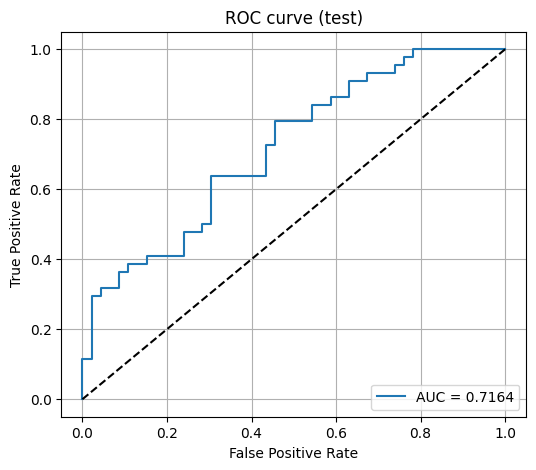

In [8]:
# EVALUATE on test set, show confusion matrix, ROC curve, save preds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
%matplotlib inline

# If you restarted kernel or lost `model`, load best checkpoint:
from pathlib import Path
MODEL_PATH = Path(r"C:\Users\aibel\Desktop\Heizel Ann Joseph\Parkinsons Disease\data\processed\pd_blstm_model.h5")
import tensorflow as tf
if 'model' not in globals():
    model = tf.keras.models.load_model(MODEL_PATH)

# Predict on test set
y_prob = model.predict(X_test, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

# Metrics
print("ROC AUC (prob):", roc_auc_score(y_test, y_prob))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# Save predictions
out_df = pd.DataFrame({"y_true": y_test, "y_pred": y_pred, "y_prob": y_prob})
OUT_CSV = Path(r"C:\Users\aibel\Desktop\Heizel Ann Joseph\Parkinsons Disease\data\processed\test_predictions.csv")
out_df.to_csv(OUT_CSV, index=False)
print("Saved test predictions to:", OUT_CSV)

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (test)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
